#00 - Configuration of Apache Spark on Collaboratory


###Installing Java, Spark, and Findspark


---


This code installs Apache Spark 2.4.4, Java 8, and [Findspark](https://github.com/minrk/findspark), a library that makes it easy for Python to find Spark.

In [251]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget  http://apache.osuosl.org/spark/spark-3.2.3/spark-3.2.3-bin-hadoop2.7.tgz   
!tar xf spark-3.2.3-bin-hadoop2.7.tgz  
!rm spark-3.2.3-bin-hadoop2.7.tgz    
!pip install -q findspark

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu focal-cran40/ InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2004/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu2004/x86_64  Release
Get:5 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Hit:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu focal InRelease
Hit:7 http://archive.ubuntu.com/ubuntu focal InRelease
Get:8 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Hit:9 http://ppa.launchpad.net/cran/libgit2/ubuntu focal InRelease
Hit:10 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu focal InRelease
Get:11 http://archive.ubuntu.com/ubuntu focal-backports InRelease [108 kB]
Hit:12 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu focal InRelease
Fetched 336 kB in 4s (92.5 kB/s)
Reading package lists... Done


In [252]:
!wget https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar

--2023-01-22 11:05:21--  https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.2-s_2.12/graphframes-0.8.2-spark3.2-s_2.12.jar
Resolving repos.spark-packages.org (repos.spark-packages.org)... 18.172.170.46, 18.172.170.21, 18.172.170.17, ...
Connecting to repos.spark-packages.org (repos.spark-packages.org)|18.172.170.46|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 247880 (242K) [binary/octet-stream]
Saving to: ‘graphframes-0.8.2-spark3.2-s_2.12.jar’

graphframes-0.8.2-s 100%[===================>] 242.07K  --.-KB/s    in 0.02s   

2023-01-22 11:05:21 (11.6 MB/s) - ‘graphframes-0.8.2-spark3.2-s_2.12.jar’ saved [247880/247880]



### Set Environment Variables
Set the locations where Spark and Java are installed.

In [253]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark/"

# à changer par ton path au dossier data
os.environ["DRIVE_DATA"] = "/content/gdrive/My Drive/Colab Notebooks/CY_Tech_BDF/data/" 

!rm /content/spark
!ln -s /content/spark-3.2.3-bin-hadoop2.7 /content/spark

!mv graphframes-0.8.2-spark3.2-s_2.12.jar /content/spark/jars/

!export SPARK_HOME=/content/spark
!export PATH=$PATH:$SPARK_HOME/bin:$SPARK_HOME/sbin

!echo $SPARK_HOME
!env |grep  "DRIVE_DATA"

!ls -l /content/


/content/spark/
DRIVE_DATA=/content/gdrive/My Drive/Colab Notebooks/CY_Tech_BDF/data/
total 12
drwx------  6 root root 4096 Jan 22 08:52 gdrive
drwxr-xr-x  1 root root 4096 Jan 19 14:35 sample_data
lrwxrwxrwx  1 root root   34 Jan 22 11:05 spark -> /content/spark-3.2.3-bin-hadoop2.7
drwxr-xr-x 13  501 1000 4096 Nov 14 18:28 spark-3.2.3-bin-hadoop2.7


### Start a SparkSession
This will start a local Spark session.

In [254]:
!python -V

import findspark
findspark.init()

from pyspark import SparkContext
sc = SparkContext.getOrCreate()

sc.addPyFile('/content/spark/jars/graphframes-0.8.2-spark3.2-s_2.12.jar')

# Example: shows the PySpark version
print("PySpark version {0}".format(sc.version))

# Example: parallelise an array and show the 2 first elements
sc.parallelize([2, 3, 4, 5, 6]).cache().take(2)

Python 3.8.10
PySpark version 3.2.3


[2, 3]

In [255]:
from pyspark.sql import SparkSession
# We create a SparkSession object (or we retrieve it if it is already created)
spark = SparkSession \
.builder \
.appName("My application") \
.config("spark.some.config.option", "some-value") \
.master("local[4]") \
.getOrCreate()
# We get the SparkContext
sc = spark.sparkContext

In [256]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).




---

# Exercises


In [257]:
# General importations (unorganised and not all finally used... also my variables' names are a complete mess, sorry)
from operator import add
from pyspark.sql import functions as f
from pyspark.sql.types import StringType,BooleanType,DateType
from pyspark.sql.functions import *
import matplotlib.pyplot as plt
import io
import numpy as np
from time import time
from random import random
import tarfile
from io import BytesIO
import bz2
from pyspark.sql.window import Window
import pyspark.sql.functions as f
from operator import itemgetter
from graphframes import *

## Exercise 3.1: Word count

Count the number of words *per line* in the $DRIVE_DATA/quijote.txt file. 

Repeat the exercise but this time counting the number of words *in the whole file*.

In [258]:
dfQuijote = spark.read.text(os.environ["DRIVE_DATA"] + "/quijote.txt")
dfQuijote.show(truncate=False)

+---------------------------------------------------------------------------+
|value                                                                      |
+---------------------------------------------------------------------------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|
|                                                                           |
|This eBook is for the use of anyone anywhere at no cost and with           |
|almost no restrictions whatsoever.  You may copy it, give it away or       |
|re-use it under the terms of the Project Gutenberg License included        |
|with this eBook or online at www.gutenberg.net                             |
|                                                                           |
|                                                                           |
|Title: Don Quijote                                                         |
|                                                               

In [259]:
# Method 1 : Number of words per line
def count_words_per_row(col_name):
  return f.size(f.split(f.col(col_name), ' '))

In [260]:
# Adding a new column containing the count of words
dfQuijote=dfQuijote.withColumn('words_count_per_row',count_words_per_row('value'))

In [261]:
# Removing empty rows
dfQuijote=dfQuijote.filter(dfQuijote.words_count_per_row!=1) 

In [262]:
dfQuijote.show(truncate=False)

+---------------------------------------------------------------------------+-------------------+
|value                                                                      |words_count_per_row|
+---------------------------------------------------------------------------+-------------------+
|The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra|12                 |
|This eBook is for the use of anyone anywhere at no cost and with           |14                 |
|almost no restrictions whatsoever.  You may copy it, give it away or       |13                 |
|re-use it under the terms of the Project Gutenberg License included        |11                 |
|with this eBook or online at www.gutenberg.net                             |7                  |
|Title: Don Quijote                                                         |3                  |
|Author: Miguel de Cervantes Saavedra                                       |5                  |
|Posting Date: April

In [263]:
# Method 2 : Total number of words
dfQuijote.groupby().sum('words_count_per_row').collect()

[Row(sum(words_count_per_row)=387237)]

## Exercise 4.1: Pi Estimation

Using the Monte Carlo method, estimate the value of Pi. Use the random() method from the random class.

In [264]:
def is_in_circle(i) :
  x,y = random(), random()
  return 1 if (x**2 + y**2 <= 1) else 0

In [265]:
inside = 0
n = 10000000

count = sc.parallelize(range(0, n)).map(is_in_circle).sum()

print("The approached value of pi is : ", count/n*4)

The approached value of pi is :  3.1416656


## Exercise 4.2: Inspect a log file

Upload the file /var/log/syslog from your computer to this notebook. Then, select only the "bad lines": WARNING and ERROR messages.

In [266]:
syslog = spark.read.text(os.environ["DRIVE_DATA"] + "/syslog")
syslog = syslog.filter(col("value").like('%ERROR%') | col("value").like('%WARNING%'))
syslog.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------



---

## Exercises 5

### Exercise 5.1: Word count

**Using RDDs**, count the number of lines in the `$DRIVE_DATA/quijote.txt` file. Then, count the number of words in the file. Finally, count the number of *different* words in the file.


In [267]:
rddQuijote = sc.textFile(os.environ["DRIVE_DATA"] + "/quijote.txt")
rddQuijote.take(5)

['The Project Gutenberg EBook of Don Quijote, by Miguel de Cervantes Saavedra',
 '',
 'This eBook is for the use of anyone anywhere at no cost and with',
 'almost no restrictions whatsoever.  You may copy it, give it away or',
 're-use it under the terms of the Project Gutenberg License included']

In [268]:
# Method 1 : Number of words per line
def count_words_per_row(row):
  return len(row.split(' '))

In [269]:
words_count_per_row=rddQuijote.map(count_words_per_row)

In [270]:
words_count_per_row.take(5)


[12, 1, 14, 13, 11]

In [271]:
# Method 2 : Total number of words
filtered_words_count_per_row=words_count_per_row.filter(lambda x: x!=1) # delete the ones of the empty lines

In [272]:
filtered_words_count_per_row.take(5)

[12, 14, 13, 11, 7]

In [273]:
words_total_count = filtered_words_count_per_row.sum()

In [274]:
print(words_total_count)

387237


### Exercise 5.2: Count people by age

Using RDDs, create a barplot showing of number of people (y-axis) per age (x-axis) using the information in the $DRIVE_DATA/people.txt file



In [275]:
rdd_people = sc.textFile(os.environ["DRIVE_DATA"] + "people.txt")
rdd_people.take(5)

['Celia\t17', 'Juan\t53', 'Manuela\t39', 'Ana\t17', 'Paco\t53']

In [276]:
rddPeopleSplitted=rdd_people.map(lambda row: row.split('\t'))

In [277]:
rddPeopleSplitted.take(5)

[['Celia', '17'],
 ['Juan', '53'],
 ['Manuela', '39'],
 ['Ana', '17'],
 ['Paco', '53']]

In [278]:
# group rdd elements by value, and sum the number of keys for each value
rddPeopleSplittedReversed=rddPeopleSplitted.map(lambda x: (x[1], 1))
rddPeopleSplittedReversed.take(5)

[('17', 1), ('53', 1), ('39', 1), ('17', 1), ('53', 1)]

In [279]:
rddPeopleSplittedReversedReduced = rddPeopleSplittedReversed.reduceByKey(lambda a,b: a+b)

In [280]:
rddPeopleSplittedReversedReduced.take(5)

[('17', 2), ('53', 2), ('40', 2), ('50', 1), ('39', 2)]

In [281]:
dfPeople = rddPeopleSplittedReversedReduced.toDF().toPandas().rename(columns= {'_1': 'Age', '_2': 'Number of people'})

In [282]:
dfPeople

,Age,Number of people
0,17,2
1,53,2
2,40,2
3,50,1
4,39,2


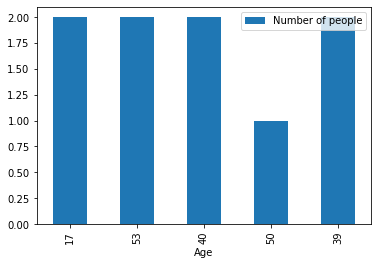

In [283]:
dfPeople.plot.bar(x='Age', y='Number of people') 

### Exercise 5.3: Obtain the number of received citations 

Using RDDs, write a PySpark program that obtains, from the cite75_99.txt file, the number of citations received by each patent. 


In [284]:
rddCitations = sc.textFile(os.environ["DRIVE_DATA"] + "/cite75_99.txt.tar.bz2", use_unicode=True)
rddCitations.take(10)

['cite75_99.txt\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00000660 \x00001750 \x00001750 \x0001757274247 13130724724 012717\x00 0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ustar\x0000jlo\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00jlo\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [285]:
rddCitations_modified=rddCitations.filter(lambda row: '\x00' not in row)

In [286]:
rddCitations_modified.take(20)
rddCitations_modified.count()

16522438

In [287]:
rddCitations_modified_Reversed = rddCitations_modified.map(lambda x: x.split(',')).map(lambda x: (x[1], 1))
rddCitations_modified_Reversed.take(5)

[('956203', 1), ('1324234', 1), ('3398406', 1), ('3557384', 1), ('3634889', 1)]

In [288]:
rddCitations_modified_Reversed_reduced = rddCitations_modified_Reversed.reduceByKey(lambda a,b: a+b)

In [289]:
rddCitations_modified_Reversed_reduced.take(10)

[('3557384', 13),
 ('2949611', 4),
 ('3146465', 14),
 ('3684611', 6),
 ('2211676', 1),
 ('3176316', 29),
 ('3699969', 34),
 ('2875449', 2),
 ('3706104', 5),
 ('3289214', 5)]

## Exercise 12.1

Let us extract information from the cite75_99.txt and apat63_99.txt files. Write a script that performs the following operations:

1. From the cite75_99.txt file, obtain the number of citations received by each patent. You must produce a DataFrame with the following format:

| PatentNum | ncitations |
|-----------|------------|
| 3060453   |    3       |
| 3390168   |    6       |
| 3626542   |   18       | 
| 3611507   |    5       |
| 3000113   |    4       |


2. From the apat63_99.txt file, create a DataFrame to show the patent number, its country and the patent year, discarding the rest of fields in the file. The DataFrame produced must have the following format:

|PatentNum |country|Year |
|----------|-------|-----|
| 3070801  | BE    | 1963| 
| 3070802  | US    | 1963| 
| 3070803  | US    | 1963| 
| 3070804  | US    | 1963| 
| 3070805  | US    | 1963|

 
**Requirements**

 - Both DataFrames must be stored in Parquet format with gzip compression. Check the number of partitions of each DataFrame and the number of files gererated.

 - It is **strongly advised** to copy the files from your Drive to a temporal directory in the notebook virtual machine and unzip them there. This will reduce the execution times. See the cell below:
        

In [290]:
!mkdir /tmp/data/
!cp "$DRIVE_DATA"apat63_99.txt.tar.bz2 "$DRIVE_DATA"cite75_99.txt.tar.bz2 /tmp/data
%cd /tmp/data
!ls
!tar -jxf apat63_99.txt.tar.bz2
!tar -jxf cite75_99.txt.tar.bz2of_citations_receiv
!rm /tmp/data/*.tar.bz2
!ls

/tmp/data
apat63_99.txt.tar.bz2  cite75_99.txt.tar.bz2
tar (child): cite75_99.txt.tar.bz2of_citations_receiv: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now
apat63_99.txt


In [291]:
# Question 1 
# Run exercice 5.3 first
columns = ["PatentNum", "ncitations"]
dfCitations_modified_Reversed_reduced = rddCitations_modified_Reversed_reduced.toDF(schema=columns)
dfCitations_modified_Reversed_reduced.show()

+---------+----------+
|PatentNum|ncitations|
+---------+----------+
|  3557384|        13|
|  2949611|         4|
|  3146465|        14|
|  3684611|         6|
|  2211676|         1|
|  3176316|        29|
|  3699969|        34|
|  2875449|         2|
|  3706104|         5|
|  3289214|         5|
|  3611446|         2|
|  3748663|         3|
|  2869141|         5|
|  1106732|         1|
|  3092049|         2|
|  3319588|         6|
|  2518060|         2|
|  2331472|         2|
|  2665963|         6|
|  2702225|         2|
+---------+----------+
only showing top 20 rows



In [292]:
# saving the df in parquet format inside the folder Data 
dfCitations_modified_Reversed_reduced.write.mode("overwrite").parquet(os.environ["DRIVE_DATA"] + "dfCitations_modified_Reversed_reduced.parquet")

In [293]:
# checking if correctly saved
temp = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .load(os.environ["DRIVE_DATA"] + "dfCitations_modified_Reversed_reduced.parquet")
temp.show()

+---------+----------+
|PatentNum|ncitations|
+---------+----------+
|  3557384|        13|
|  2949611|         4|
|  3146465|        14|
|  3684611|         6|
|  2211676|         1|
|  3176316|        29|
|  3699969|        34|
|  2875449|         2|
|  3706104|         5|
|  3289214|         5|
|  3611446|         2|
|  3748663|         3|
|  2869141|         5|
|  1106732|         1|
|  3092049|         2|
|  3319588|         6|
|  2518060|         2|
|  2331472|         2|
|  2665963|         6|
|  2702225|         2|
+---------+----------+
only showing top 20 rows



In [294]:
# Question 2

rddApat = sc.textFile(os.environ["DRIVE_DATA"] + "/apat63_99.txt.tar.bz2", use_unicode=True)
rddApat.take(10)

['apat63_99.txt\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00000660 \x00001750 \x00001750 \x0001607555413 13130732465 012705\x00 0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ustar\x0000jlo\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00jlo\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [295]:
rddApat_modified=rddApat.filter(lambda row: '\x00' not in row)

In [296]:
rddApat_modified.take(20)

['3070801,1963,1096,,"BE","",,1,,269,6,69,,1,,0,,,,,,,',
 '3070802,1963,1096,,"US","TX",,1,,2,6,63,,0,,,,,,,,,',
 '3070803,1963,1096,,"US","IL",,1,,2,6,63,,9,,0.3704,,,,,,,',
 '3070804,1963,1096,,"US","OH",,1,,2,6,63,,3,,0.6667,,,,,,,',
 '3070805,1963,1096,,"US","CA",,1,,2,6,63,,1,,0,,,,,,,',
 '3070806,1963,1096,,"US","PA",,1,,2,6,63,,0,,,,,,,,,',
 '3070807,1963,1096,,"US","OH",,1,,623,3,39,,3,,0.4444,,,,,,,',
 '3070808,1963,1096,,"US","IA",,1,,623,3,39,,4,,0.375,,,,,,,',
 '3070809,1963,1096,,"US","AZ",,1,,4,6,65,,0,,,,,,,,,',
 '3070810,1963,1096,,"US","IL",,1,,4,6,65,,3,,0.4444,,,,,,,',
 '3070811,1963,1096,,"US","CA",,1,,4,6,65,,8,,0,,,,,,,',
 '3070812,1963,1096,,"US","LA",,1,,4,6,65,,3,,0.4444,,,,,,,',
 '3070813,1963,1096,,"US","NY",,1,,5,6,65,,2,,0,,,,,,,',
 '3070814,1963,1096,,"US","MN",,2,,267,5,59,,2,,0.5,,,,,,,',
 '3070815,1963,1096,,"US","CO",,1,,7,5,59,,1,,0,,,,,,,',
 '3070816,1963,1096,,"US","OK",,1,,114,5,55,,4,,0,,,,,,,',
 '3070817,1963,1096,,"US","RI",,2,,114,5,55,,5,,0.64

In [297]:
rddApat_modified_Splitted = rddApat_modified.map(lambda x: x.split(','))
rddApat_modified_Splitted.take(2)

[['3070801',
  '1963',
  '1096',
  '',
  '"BE"',
  '""',
  '',
  '1',
  '',
  '269',
  '6',
  '69',
  '',
  '1',
  '',
  '0',
  '',
  '',
  '',
  '',
  '',
  '',
  ''],
 ['3070802',
  '1963',
  '1096',
  '',
  '"US"',
  '"TX"',
  '',
  '1',
  '',
  '2',
  '6',
  '63',
  '',
  '0',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '']]

In [298]:
columns = ["PatentNum", "ncitations"]
dfApat=rddApat_modified_Splitted.toDF()
dfApat.show()

+-------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+------+---+---+---+---+---+---+---+
|     _1|  _2|  _3| _4|  _5|  _6| _7| _8| _9|_10|_11|_12|_13|_14|_15|   _16|_17|_18|_19|_20|_21|_22|_23|
+-------+----+----+---+----+----+---+---+---+---+---+---+---+---+---+------+---+---+---+---+---+---+---+
|3070801|1963|1096|   |"BE"|  ""|   |  1|   |269|  6| 69|   |  1|   |     0|   |   |   |   |   |   |   |
|3070802|1963|1096|   |"US"|"TX"|   |  1|   |  2|  6| 63|   |  0|   |      |   |   |   |   |   |   |   |
|3070803|1963|1096|   |"US"|"IL"|   |  1|   |  2|  6| 63|   |  9|   |0.3704|   |   |   |   |   |   |   |
|3070804|1963|1096|   |"US"|"OH"|   |  1|   |  2|  6| 63|   |  3|   |0.6667|   |   |   |   |   |   |   |
|3070805|1963|1096|   |"US"|"CA"|   |  1|   |  2|  6| 63|   |  1|   |     0|   |   |   |   |   |   |   |
|3070806|1963|1096|   |"US"|"PA"|   |  1|   |  2|  6| 63|   |  0|   |      |   |   |   |   |   |   |   |
|3070807|1963|1096|   |"US"|"OH"|   |  1|   |623|  3| 3

In [299]:
columns = ["PatentNum", "country", "Year"]
dfApat_small = dfApat.select("_1", "_5", "_2").toDF(*columns)
dfApat_small.show()

+---------+-------+----+
|PatentNum|country|Year|
+---------+-------+----+
|  3070801|   "BE"|1963|
|  3070802|   "US"|1963|
|  3070803|   "US"|1963|
|  3070804|   "US"|1963|
|  3070805|   "US"|1963|
|  3070806|   "US"|1963|
|  3070807|   "US"|1963|
|  3070808|   "US"|1963|
|  3070809|   "US"|1963|
|  3070810|   "US"|1963|
|  3070811|   "US"|1963|
|  3070812|   "US"|1963|
|  3070813|   "US"|1963|
|  3070814|   "US"|1963|
|  3070815|   "US"|1963|
|  3070816|   "US"|1963|
|  3070817|   "US"|1963|
|  3070818|   "US"|1963|
|  3070819|   "US"|1963|
|  3070820|   "GB"|1963|
+---------+-------+----+
only showing top 20 rows



In [300]:
# saving the df in parquet format inside the folder Data 
dfApat_small.write.mode("overwrite").parquet(os.environ["DRIVE_DATA"] + "dfApat_small.parquet")

In [301]:
# checking if correctly saved
temp = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .load(os.environ["DRIVE_DATA"] + "dfApat_small.parquet")
temp.show()

+---------+-------+----+
|PatentNum|country|Year|
+---------+-------+----+
|  3070801|   "BE"|1963|
|  3070802|   "US"|1963|
|  3070803|   "US"|1963|
|  3070804|   "US"|1963|
|  3070805|   "US"|1963|
|  3070806|   "US"|1963|
|  3070807|   "US"|1963|
|  3070808|   "US"|1963|
|  3070809|   "US"|1963|
|  3070810|   "US"|1963|
|  3070811|   "US"|1963|
|  3070812|   "US"|1963|
|  3070813|   "US"|1963|
|  3070814|   "US"|1963|
|  3070815|   "US"|1963|
|  3070816|   "US"|1963|
|  3070817|   "US"|1963|
|  3070818|   "US"|1963|
|  3070819|   "US"|1963|
|  3070820|   "GB"|1963|
+---------+-------+----+
only showing top 20 rows



## Exercise 12.2

Write a code that, from the Parquet files created in the previous exercise, obtains for each country and for each year: the total number of patents, the total number of citations from those patents, the average number of citations and the maximum number of citations. Compute only those values in which there are any values in both files (*inner join*). In addition, each country must show its whole name, obtained from the *country_codes.txt* file. The final DataFrame must look like this one:


|Country            |Year|PatentsNum |TotalCitations|AvgCitations      |MaxCitations|
|-------------------|----|-----------|--------------|------------------|------------|
|Algeria            |1963|2          |7             |3.5               |4           |
|Algeria            |1968|1          |2             |2.0               |2           |
|Algeria            |1970|1          |2             |2.0               |2           |
|Algeria            |1972|1          |1             |1.0               |1           |
|Algeria            |1977|1          |2             |2.0               |2           |
|Andorra            |1987|1          |3             |3.0               |3           |
|Andorra            |1993|1          |1             |1.0               |1           |
|Andorra            |1998|1          |1             |1.0               |1           |
|Antigua and Barbuda|1978|1          |6             |6.0               |6           |
|Antigua and Barbuda|1979|1          |14            |14.0              |14          |
|Antigua and Barbuda|1991|1          |8             |8.0               |8           |
|Antigua and Barbuda|1994|1          |19            |19.0              |19          |
|Antigua and Barbuda|1995|2          |12            |6.0               |11          |
|Antigua and Barbuda|1996|2          |3             |1.5               |2           |
|Argentina          |1963|14         |35            |2.5               |7           |
|Argentina          |1964|20         |60            |3.0               |8           |
|Argentina          |1965|10         |35            |3.5               |10          |
|Argentina          |1966|16         |44            |2.75              |9           |
|Argentina          |1967|13         |60            |4.615384615384615 |14          |

**Requirements**

- The output DataFrame must be saved in a single CSV file, with a header and without any compression.


In [302]:
# Loading parquet files

dfApat = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .load(os.environ["DRIVE_DATA"] + "dfApat_small.parquet")
dfApat.show(truncate=False)

dfCitations = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .load(os.environ["DRIVE_DATA"] + "dfCitations_modified_Reversed_reduced.parquet")
dfCitations.show(truncate=False)

+---------+-------+----+
|PatentNum|country|Year|
+---------+-------+----+
|3070801  |"BE"   |1963|
|3070802  |"US"   |1963|
|3070803  |"US"   |1963|
|3070804  |"US"   |1963|
|3070805  |"US"   |1963|
|3070806  |"US"   |1963|
|3070807  |"US"   |1963|
|3070808  |"US"   |1963|
|3070809  |"US"   |1963|
|3070810  |"US"   |1963|
|3070811  |"US"   |1963|
|3070812  |"US"   |1963|
|3070813  |"US"   |1963|
|3070814  |"US"   |1963|
|3070815  |"US"   |1963|
|3070816  |"US"   |1963|
|3070817  |"US"   |1963|
|3070818  |"US"   |1963|
|3070819  |"US"   |1963|
|3070820  |"GB"   |1963|
+---------+-------+----+
only showing top 20 rows

+---------+----------+
|PatentNum|ncitations|
+---------+----------+
|3557384  |13        |
|2949611  |4         |
|3146465  |14        |
|3684611  |6         |
|2211676  |1         |
|3176316  |29        |
|3699969  |34        |
|2875449  |2         |
|3706104  |5         |
|3289214  |5         |
|3611446  |2         |
|3748663  |3         |
|2869141  |5         |
|11067

In [303]:
# Fixing Country Codes file

tempCountryCodes = spark.read\
            .text(os.environ["DRIVE_DATA"] + "/country_codes.txt")

dfCountryCodes = tempCountryCodes.withColumn('lists', f.split(tempCountryCodes['value'], '\t')).select('lists')

dfCountryCodes = dfCountryCodes.withColumn('code', dfCountryCodes['lists'][0])\
                  .withColumn('country', dfCountryCodes['lists'][1])\
                  .select('code', 'country')\
                  .withColumn("temp", lit("\""))
                  
dfCountryCodes = dfCountryCodes\
                  .select(concat(dfCountryCodes.temp, dfCountryCodes.code, dfCountryCodes.temp).alias('code'), 'country')

dfCountryCodes.show()

+----+-------------------+
|code|            country|
+----+-------------------+
|"AF"|        Afghanistan|
|"AX"|      Aland Islands|
|"AL"|            Albania|
|"DZ"|            Algeria|
|"AS"|     American Samoa|
|"AD"|            Andorra|
|"AO"|             Angola|
|"AI"|           Anguilla|
|"AQ"|         Antarctica|
|"AG"|Antigua and Barbuda|
|"AR"|          Argentina|
|"AM"|            Armenia|
|"AW"|              Aruba|
|"AC"|   Ascension Island|
|"AU"|          Australia|
|"AT"|            Austria|
|"AZ"|         Azerbaijan|
|"BS"|            Bahamas|
|"BH"|            Bahrain|
|"BD"|         Bangladesh|
+----+-------------------+
only showing top 20 rows



In [304]:
initialJointDF = dfApat.join(dfCitations, dfApat.PatentNum == dfCitations.PatentNum, "inner").drop(dfCitations.PatentNum)
initialJointDF.show()

+---------+-------+----+----------+
|PatentNum|country|Year|ncitations|
+---------+-------+----+----------+
|  3070803|   "US"|1963|         9|
|  3070804|   "US"|1963|         3|
|  3070807|   "US"|1963|         3|
|  3070810|   "US"|1963|         3|
|  3070812|   "US"|1963|         3|
|  3070816|   "US"|1963|         4|
|  3070823|   "US"|1963|         8|
|  3070824|   "US"|1963|         5|
|  3070828|   "US"|1963|         4|
|  3070829|   "FR"|1963|         5|
|  3070832|   "US"|1963|         1|
|  3070833|   "US"|1963|         5|
|  3070836|   "US"|1963|        24|
|  3070839|   "US"|1963|         8|
|  3070840|   "GB"|1963|         6|
|  3070845|   "US"|1963|         3|
|  3070846|   "US"|1963|         9|
|  3070848|   "DE"|1963|         1|
|  3070850|   "US"|1963|        10|
|  3070852|   "US"|1963|         7|
+---------+-------+----+----------+
only showing top 20 rows



In [305]:
jointDF = initialJointDF.join(dfCountryCodes, initialJointDF.country == dfCountryCodes.code, "inner")\
                        .drop(initialJointDF.country)\
                        .select('country', 'Year','PatentNum', 'ncitations')\
                        .withColumnRenamed("country", "Country")\
                        .withColumnRenamed("PatentNum", "PatentsNum")\
                        .withColumnRenamed("ncitations", "TotalCitations")
jointDF.show()

+------------------+----+----------+--------------+
|           Country|Year|PatentsNum|TotalCitations|
+------------------+----+----------+--------------+
|     United States|1963|   3070803|             9|
|     United States|1963|   3070804|             3|
|     United States|1963|   3070807|             3|
|     United States|1963|   3070810|             3|
|     United States|1963|   3070812|             3|
|     United States|1963|   3070816|             4|
|     United States|1963|   3070823|             8|
|     United States|1963|   3070824|             5|
|     United States|1963|   3070828|             4|
|            France|1963|   3070829|             5|
|     United States|1963|   3070832|             1|
|     United States|1963|   3070833|             5|
|     United States|1963|   3070836|            24|
|     United States|1963|   3070839|             8|
|Great Britain (UK)|1963|   3070840|             6|
|     United States|1963|   3070845|             3|
|     United

In [306]:
# Column containing average number of citations per year per country
group_cols = ["Country", "Year"]
groupedJointDF = jointDF.groupBy(group_cols).agg(avg("TotalCitations").alias("AvgCitations"), max("TotalCitations").alias("MaxCitations")).sort(col("Country"),col("Year"))
groupedJointDF.show()

+-------------------+----+-----------------+------------+
|            Country|Year|     AvgCitations|MaxCitations|
+-------------------+----+-----------------+------------+
|            Algeria|1963|              3.5|           4|
|            Algeria|1968|              2.0|           2|
|            Algeria|1970|              2.0|           2|
|            Algeria|1972|              1.0|           1|
|            Algeria|1977|              2.0|           2|
|            Andorra|1987|              3.0|           3|
|            Andorra|1993|              1.0|           1|
|            Andorra|1998|              1.0|           1|
|Antigua and Barbuda|1978|              6.0|           6|
|Antigua and Barbuda|1979|             14.0|          14|
|Antigua and Barbuda|1991|              8.0|           8|
|Antigua and Barbuda|1994|             19.0|          19|
|Antigua and Barbuda|1995|              6.0|          11|
|Antigua and Barbuda|1996|              1.5|           2|
|          Arg

In [307]:
responseDF = jointDF.join(groupedJointDF, group_cols)
responseDF.show()

+-------+----+----------+--------------+-----------------+------------+
|Country|Year|PatentsNum|TotalCitations|     AvgCitations|MaxCitations|
+-------+----+----------+--------------+-----------------+------------+
|  Italy|1963|   3071049|             2|3.304932735426009|          21|
|  Italy|1963|   3071820|             1|3.304932735426009|          21|
|  Italy|1963|   3072084|             2|3.304932735426009|          21|
|  Italy|1963|   3072862|             1|3.304932735426009|          21|
|  Italy|1963|   3073194|             1|3.304932735426009|          21|
|  Italy|1963|   3073441|             4|3.304932735426009|          21|
|  Italy|1963|   3073667|             2|3.304932735426009|          21|
|  Italy|1963|   3073741|             1|3.304932735426009|          21|
|  Italy|1963|   3073997|            10|3.304932735426009|          21|
|  Italy|1963|   3074339|             4|3.304932735426009|          21|
|  Italy|1963|   3074382|             2|3.304932735426009|      

In [308]:
# The output file should be a csv
responseDF.write.mode('overwrite').csv(os.environ["DRIVE_DATA"] + "responseCSV.csv",header = 'true')

## Exercise 12.3

From the apat63_99.txt file, obtain the number of patents per country and year **using RDDs** (do not use DataFrames). The resulting RDD must be a key/value RDD in which the key is a country and the value a list of tuples. Each tuple will be composed of a year and the number of patents of the country during that year. In addition, the resulting RDD must be sorted by  the country code and, for each country, values must be sorted by year.

Example of output key/value entry:

    (u'PA', [(u'1963', 2), (u'1964', 2), (u'1965', 1), (u'1966', 1), (u'1970', 1), (u'1971', 1), (u'1972', 6), (u'1974', 3), (u'1975', 5), (u'1976', 3), (u'1977', 2), (u'1978', 2), (u'1980', 2), (u'1982', 1), (u'1983', 1), (u'1985', 2), (u'1986', 1), (u'1987', 2), (u'1988', 1), (u'1990', 1), (u'1991', 2), (u'1993', 1), (u'1995', 1), (u'1996', 1), (u'1999', 1)])

**Requirements:**

- You must remove the double quotation marks from the country code.
- Use 8 partitions to read the apat63_99.txt.bz2 file.


In [309]:
rddApat = sc.textFile(os.environ["DRIVE_DATA"] + "/apat63_99.txt.tar.bz2", use_unicode=True)
rddApat.take(10)

['apat63_99.txt\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00000660 \x00001750 \x00001750 \x0001607555413 13130732465 012705\x00 0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00ustar\x0000jlo\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00jlo\x00\x00\x00\x00\x00\x00\x00\x00\x0

In [310]:
rddApat_modified=rddApat.filter(lambda row: '\x00' not in row)

In [311]:
rddApat_modified.take(5)

['3070801,1963,1096,,"BE","",,1,,269,6,69,,1,,0,,,,,,,',
 '3070802,1963,1096,,"US","TX",,1,,2,6,63,,0,,,,,,,,,',
 '3070803,1963,1096,,"US","IL",,1,,2,6,63,,9,,0.3704,,,,,,,',
 '3070804,1963,1096,,"US","OH",,1,,2,6,63,,3,,0.6667,,,,,,,',
 '3070805,1963,1096,,"US","CA",,1,,2,6,63,,1,,0,,,,,,,']

In [312]:
rddApat_modified_Splitted = rddApat_modified.map(lambda x: x.split(","))
rddApat_modified_Splitted.take(2)

[['3070801',
  '1963',
  '1096',
  '',
  '"BE"',
  '""',
  '',
  '1',
  '',
  '269',
  '6',
  '69',
  '',
  '1',
  '',
  '0',
  '',
  '',
  '',
  '',
  '',
  '',
  ''],
 ['3070802',
  '1963',
  '1096',
  '',
  '"US"',
  '"TX"',
  '',
  '1',
  '',
  '2',
  '6',
  '63',
  '',
  '0',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '']]

In [313]:
rddApat_modified_Splitted2 = rddApat_modified_Splitted.map(lambda x: ((x[4], x[1]), 1))
rddApat_modified_Splitted2.take(10)

[(('"BE"', '1963'), 1),
 (('"US"', '1963'), 1),
 (('"US"', '1963'), 1),
 (('"US"', '1963'), 1),
 (('"US"', '1963'), 1),
 (('"US"', '1963'), 1),
 (('"US"', '1963'), 1),
 (('"US"', '1963'), 1),
 (('"US"', '1963'), 1),
 (('"US"', '1963'), 1)]

In [314]:
rddApat_modified_Splitted3 = rddApat_modified_Splitted2.reduceByKey( lambda x,y: x+y ).map(lambda x: (x[0][0].split("\"")[1],(x[0][1], x[1])))
rddApat_modified_Splitted3.take(5)

[('BE', ('1963', 85)),
 ('FR', ('1963', 853)),
 ('CH', ('1963', 668)),
 ('SE', ('1963', 386)),
 ('JP', ('1963', 407))]

In [315]:
rddApat_modified_Splitted4 = rddApat_modified_Splitted3.sortBy(lambda x: (x[0], x[1][0]))

rddApat_modified_Splitted4.take(5)

[('AD', ('1987', 1)),
 ('AD', ('1993', 1)),
 ('AD', ('1995', 1)),
 ('AD', ('1998', 2)),
 ('AD', ('1999', 1))]

In [316]:
def to_list(a):
    return [a]
def append(a, b):
    a.append(b)
    return a
def extend(a, b):
    a.extend(b)
    return a

rddApat_modified_Splitted5 = rddApat_modified_Splitted4.combineByKey(to_list, append, extend)
rddApat_modified_Splitted5.take(2)

[('AG',
  [('1978', 1),
   ('1979', 1),
   ('1991', 1),
   ('1994', 1),
   ('1995', 2),
   ('1996', 2),
   ('1999', 1)]),
 ('AR',
  [('1963', 19),
   ('1964', 27),
   ('1965', 18),
   ('1966', 20),
   ('1967', 16),
   ('1968', 18),
   ('1969', 17),
   ('1970', 23),
   ('1971', 22),
   ('1972', 29),
   ('1973', 28),
   ('1974', 24),
   ('1975', 24),
   ('1976', 24),
   ('1977', 20),
   ('1978', 21),
   ('1979', 24),
   ('1980', 18),
   ('1981', 25),
   ('1982', 18),
   ('1983', 21),
   ('1984', 20),
   ('1985', 11),
   ('1986', 17),
   ('1987', 18),
   ('1988', 16),
   ('1989', 20),
   ('1990', 17),
   ('1991', 16),
   ('1992', 20),
   ('1993', 24),
   ('1994', 32),
   ('1995', 31),
   ('1996', 30),
   ('1997', 35),
   ('1998', 43),
   ('1999', 44)])]

## Exercise 12.4

From the Parquet files created in Exercise 12.1, create a DataFrame that gives the patent or patents with the higher number of citations per country and year, as well as the average of the number of citations per country and year, and the difference between the maximum and the average values. The resulting DataFrame should look like this:


|Country|Year|PatentNum|max  |average       |diff              |
|-------|----|---------|-----|--------------|------------------|
|AD     |1987|4688621  |3    |3.0           |0.0               |
|AD     |1993|5193231  |1    |1.0           |0.0               |
|AD     |1998|5765303  |1    |1.0           |0.0               |
|AE     |1984|4482959  |5    |5.0           |0.0               |
|AE     |1985|4554981  |14   |14.0          |0.0               |
|AE     |1987|4663181  |3    |3.0           |0.0               |
|AE     |1989|4805221  |7    |5.0           |2.0               |
|AE     |1990|4909321  |2    |2.0           |0.0               |
|AE     |1991|5004552  |3    |2.0           |1.0               |
|AE     |1992|5104556  |4    |4.0           |0.0               |
|AE     |1993|5181569  |8    |8.0           |0.0               |
|AE     |1996|5580125  |1    |1.0           |0.0               |
|AG     |1978|4126850  |6    |6.0           |0.0               |
|AG     |1979|4172981  |14   |14.0          |0.0               |
|AG     |1991|5013035  |8    |8.0           |0.0               |
|AG     |1994|5345071  |19   |19.0          |0.0               |
|AG     |1995|5457307  |11   |6.0           |5.0               |
|AG     |1996|5525786  |2    |1.5           |0.5               |

**Requirements:**

- The DataFrame must be sorted by country code and year.
- Do **NOT** replace the country code by its whole name.
- The output must be saved as a single CSV file, with a header and without any compression.


In [317]:
dfApatFromParquet = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .load(os.environ["DRIVE_DATA"] + "dfApat_small.parquet")
dfApatFromParquet.show()

+---------+-------+----+
|PatentNum|country|Year|
+---------+-------+----+
|  3070801|   "BE"|1963|
|  3070802|   "US"|1963|
|  3070803|   "US"|1963|
|  3070804|   "US"|1963|
|  3070805|   "US"|1963|
|  3070806|   "US"|1963|
|  3070807|   "US"|1963|
|  3070808|   "US"|1963|
|  3070809|   "US"|1963|
|  3070810|   "US"|1963|
|  3070811|   "US"|1963|
|  3070812|   "US"|1963|
|  3070813|   "US"|1963|
|  3070814|   "US"|1963|
|  3070815|   "US"|1963|
|  3070816|   "US"|1963|
|  3070817|   "US"|1963|
|  3070818|   "US"|1963|
|  3070819|   "US"|1963|
|  3070820|   "GB"|1963|
+---------+-------+----+
only showing top 20 rows



In [318]:
dfCitationsFromParquet = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .load(os.environ["DRIVE_DATA"] + "dfCitations_modified_Reversed_reduced.parquet")
dfCitationsFromParquet.show()

+---------+----------+
|PatentNum|ncitations|
+---------+----------+
|  3557384|        13|
|  2949611|         4|
|  3146465|        14|
|  3684611|         6|
|  2211676|         1|
|  3176316|        29|
|  3699969|        34|
|  2875449|         2|
|  3706104|         5|
|  3289214|         5|
|  3611446|         2|
|  3748663|         3|
|  2869141|         5|
|  1106732|         1|
|  3092049|         2|
|  3319588|         6|
|  2518060|         2|
|  2331472|         2|
|  2665963|         6|
|  2702225|         2|
+---------+----------+
only showing top 20 rows



In [319]:
initialJointDF = dfApat.join(dfCitations, dfApat.PatentNum == dfCitations.PatentNum, "inner")\
                        .drop(dfCitations.PatentNum)\
                        .select("country", "Year", "PatentNum", "ncitations")
initialJointDF.show()

+-------+----+---------+----------+
|country|Year|PatentNum|ncitations|
+-------+----+---------+----------+
|   "US"|1963|  3070803|         9|
|   "US"|1963|  3070804|         3|
|   "US"|1963|  3070807|         3|
|   "US"|1963|  3070810|         3|
|   "US"|1963|  3070812|         3|
|   "US"|1963|  3070816|         4|
|   "US"|1963|  3070823|         8|
|   "US"|1963|  3070824|         5|
|   "US"|1963|  3070828|         4|
|   "FR"|1963|  3070829|         5|
|   "US"|1963|  3070832|         1|
|   "US"|1963|  3070833|         5|
|   "US"|1963|  3070836|        24|
|   "US"|1963|  3070839|         8|
|   "GB"|1963|  3070840|         6|
|   "US"|1963|  3070845|         3|
|   "US"|1963|  3070846|         9|
|   "DE"|1963|  3070848|         1|
|   "US"|1963|  3070850|        10|
|   "US"|1963|  3070852|         7|
+-------+----+---------+----------+
only showing top 20 rows



In [320]:
group_cols = ["country", "Year"]
groupedJointDF = initialJointDF.groupBy(group_cols).agg(max("ncitations").alias("max"), avg("ncitations").alias("average")).sort(col("country"),col("Year"))
groupedJointDF.show()

+-------+----+---+-------+
|country|Year|max|average|
+-------+----+---+-------+
|   "AD"|1987|  3|    3.0|
|   "AD"|1993|  1|    1.0|
|   "AD"|1998|  1|    1.0|
|   "AE"|1984|  5|    5.0|
|   "AE"|1985| 14|   14.0|
|   "AE"|1987|  3|    3.0|
|   "AE"|1989|  7|    5.0|
|   "AE"|1990|  2|    2.0|
|   "AE"|1991|  3|    2.0|
|   "AE"|1992|  4|    4.0|
|   "AE"|1993|  8|    8.0|
|   "AE"|1996|  1|    1.0|
|   "AG"|1978|  6|    6.0|
|   "AG"|1979| 14|   14.0|
|   "AG"|1991|  8|    8.0|
|   "AG"|1994| 19|   19.0|
|   "AG"|1995| 11|    6.0|
|   "AG"|1996|  2|    1.5|
|   "AM"|1995|  2|    2.0|
|   "AN"|1979|  1|    1.0|
+-------+----+---+-------+
only showing top 20 rows



In [321]:
groupedJointDF = groupedJointDF.withColumn("diff", col('max')-col('average'))
groupedJointDF.show()

+-------+----+---+-------+----+
|country|Year|max|average|diff|
+-------+----+---+-------+----+
|   "AD"|1987|  3|    3.0| 0.0|
|   "AD"|1993|  1|    1.0| 0.0|
|   "AD"|1998|  1|    1.0| 0.0|
|   "AE"|1984|  5|    5.0| 0.0|
|   "AE"|1985| 14|   14.0| 0.0|
|   "AE"|1987|  3|    3.0| 0.0|
|   "AE"|1989|  7|    5.0| 2.0|
|   "AE"|1990|  2|    2.0| 0.0|
|   "AE"|1991|  3|    2.0| 1.0|
|   "AE"|1992|  4|    4.0| 0.0|
|   "AE"|1993|  8|    8.0| 0.0|
|   "AE"|1996|  1|    1.0| 0.0|
|   "AG"|1978|  6|    6.0| 0.0|
|   "AG"|1979| 14|   14.0| 0.0|
|   "AG"|1991|  8|    8.0| 0.0|
|   "AG"|1994| 19|   19.0| 0.0|
|   "AG"|1995| 11|    6.0| 5.0|
|   "AG"|1996|  2|    1.5| 0.5|
|   "AM"|1995|  2|    2.0| 0.0|
|   "AN"|1979|  1|    1.0| 0.0|
+-------+----+---+-------+----+
only showing top 20 rows



In [322]:
newerJointDF = initialJointDF.join(groupedJointDF, group_cols).sort(col("country"),col("Year"))
newerJointDF.show()

+-------+----+---------+----------+---+-------+----+
|country|Year|PatentNum|ncitations|max|average|diff|
+-------+----+---------+----------+---+-------+----+
|   "AD"|1987|  4688621|         3|  3|    3.0| 0.0|
|   "AD"|1993|  5193231|         1|  1|    1.0| 0.0|
|   "AD"|1998|  5765303|         1|  1|    1.0| 0.0|
|   "AE"|1984|  4482959|         5|  5|    5.0| 0.0|
|   "AE"|1985|  4554981|        14| 14|   14.0| 0.0|
|   "AE"|1987|  4663181|         3|  3|    3.0| 0.0|
|   "AE"|1989|  4805221|         7|  7|    5.0| 2.0|
|   "AE"|1989|  4813707|         3|  7|    5.0| 2.0|
|   "AE"|1990|  4909321|         2|  2|    2.0| 0.0|
|   "AE"|1991|  5004552|         3|  3|    2.0| 1.0|
|   "AE"|1991|  4997041|         1|  3|    2.0| 1.0|
|   "AE"|1992|  5104556|         4|  4|    4.0| 0.0|
|   "AE"|1993|  5181569|         8|  8|    8.0| 0.0|
|   "AE"|1996|  5580125|         1|  1|    1.0| 0.0|
|   "AG"|1978|  4126850|         6|  6|    6.0| 0.0|
|   "AG"|1979|  4172981|        14| 14|   14.0

In [323]:
newerJointDF = newerJointDF.where(newerJointDF.ncitations == newerJointDF.max).select("country", "Year", "PatentNum","max", "average", "diff")
newerJointDF.show()

+-------+----+---------+---+-------+----+
|country|Year|PatentNum|max|average|diff|
+-------+----+---------+---+-------+----+
|   "AD"|1987|  4688621|  3|    3.0| 0.0|
|   "AD"|1993|  5193231|  1|    1.0| 0.0|
|   "AD"|1998|  5765303|  1|    1.0| 0.0|
|   "AE"|1984|  4482959|  5|    5.0| 0.0|
|   "AE"|1985|  4554981| 14|   14.0| 0.0|
|   "AE"|1987|  4663181|  3|    3.0| 0.0|
|   "AE"|1989|  4805221|  7|    5.0| 2.0|
|   "AE"|1990|  4909321|  2|    2.0| 0.0|
|   "AE"|1991|  5004552|  3|    2.0| 1.0|
|   "AE"|1992|  5104556|  4|    4.0| 0.0|
|   "AE"|1993|  5181569|  8|    8.0| 0.0|
|   "AE"|1996|  5580125|  1|    1.0| 0.0|
|   "AG"|1978|  4126850|  6|    6.0| 0.0|
|   "AG"|1979|  4172981| 14|   14.0| 0.0|
|   "AG"|1991|  5013035|  8|    8.0| 0.0|
|   "AG"|1994|  5345071| 19|   19.0| 0.0|
|   "AG"|1995|  5457307| 11|    6.0| 5.0|
|   "AG"|1996|  5525786|  2|    1.5| 0.5|
|   "AM"|1995|  5382341|  2|    2.0| 0.0|
|   "AN"|1979|  4165701|  1|    1.0| 0.0|
+-------+----+---------+---+------

In [324]:
# The output file should be a csv
newerJointDF.write.mode('overwrite').csv(os.environ["DRIVE_DATA"] + "newerJointDF.csv",header = 'true')

## Exercise 12.5

From the Parquet file with the (PatentNum,Country,Year) information from Exercise 12.1, create a DataFrame that shows the number of patents associated to each country per decade (understanding as a *decade* the years from 0 to 9; e.g. from 1970 to 1979). In addition, the DataFrame must show the increase or decrease of the number of patents per country and decade with respect to the previous decade. The resulting DataFrame must look like this:

|Country|Decade|PatentsNum|Diff|
|-------|------|----------|----|
|AD     |1980  |1         |0   |
|AD     |1990  |5         |4   |
|AE     |1980  |7         |0   |
|AE     |1990  |11        |4   |
|AG     |1970  |2         |0   |
|AG     |1990  |7         |5   |
|AI     |1990  |1         |0   |
|AL     |1990  |1         |0   |
|AM     |1990  |2         |0   |
|AN     |1970  |1         |0   |
|AN     |1980  |2         |1   |
|AN     |1990  |5         |3   |
|AR     |1960  |135       |0   |
|AR     |1970  |239       |104 |
|AR     |1980  |184       |-55 |
|AR     |1990  |292       |108 |

**Requirements**

- The DataFrame must be sorted by country code and year.
- Do **NOT** replace the country code by its whole name.
- The output must be saved as a single CSV file, with a header and without any compression.

In [325]:
dfApatFromParquet = spark.read\
            .format("parquet")\
            .option("mode", "FAILFAST")\
            .load(os.environ["DRIVE_DATA"] + "dfApat_small.parquet")
dfApatFromParquet.show()

+---------+-------+----+
|PatentNum|country|Year|
+---------+-------+----+
|  3070801|   "BE"|1963|
|  3070802|   "US"|1963|
|  3070803|   "US"|1963|
|  3070804|   "US"|1963|
|  3070805|   "US"|1963|
|  3070806|   "US"|1963|
|  3070807|   "US"|1963|
|  3070808|   "US"|1963|
|  3070809|   "US"|1963|
|  3070810|   "US"|1963|
|  3070811|   "US"|1963|
|  3070812|   "US"|1963|
|  3070813|   "US"|1963|
|  3070814|   "US"|1963|
|  3070815|   "US"|1963|
|  3070816|   "US"|1963|
|  3070817|   "US"|1963|
|  3070818|   "US"|1963|
|  3070819|   "US"|1963|
|  3070820|   "GB"|1963|
+---------+-------+----+
only showing top 20 rows



In [326]:
dfApatFromParquet = dfApatFromParquet.withColumn("Decade", (f.floor(dfApatFromParquet["Year"]/10)*10)\
                                                .cast("int"))\
                                                .drop("Year")\
                                                .select("Country", "Decade", "PatentNum")
dfApatFromParquet.show()

+-------+------+---------+
|Country|Decade|PatentNum|
+-------+------+---------+
|   "BE"|  1960|  3070801|
|   "US"|  1960|  3070802|
|   "US"|  1960|  3070803|
|   "US"|  1960|  3070804|
|   "US"|  1960|  3070805|
|   "US"|  1960|  3070806|
|   "US"|  1960|  3070807|
|   "US"|  1960|  3070808|
|   "US"|  1960|  3070809|
|   "US"|  1960|  3070810|
|   "US"|  1960|  3070811|
|   "US"|  1960|  3070812|
|   "US"|  1960|  3070813|
|   "US"|  1960|  3070814|
|   "US"|  1960|  3070815|
|   "US"|  1960|  3070816|
|   "US"|  1960|  3070817|
|   "US"|  1960|  3070818|
|   "US"|  1960|  3070819|
|   "GB"|  1960|  3070820|
+-------+------+---------+
only showing top 20 rows



In [327]:
rddApatFromParquet1 = dfApatFromParquet.sort(col("country"))\
                                      .rdd\
                                      .map(lambda x: ((x[0],x[1]),1))\
                                      .reduceByKey(lambda a,b: a+b)
rddApatFromParquet1.take(10)

[(('"AD"', 1980), 1),
 (('"AD"', 1990), 5),
 (('"AE"', 1980), 7),
 (('"AE"', 1990), 11),
 (('"AG"', 1970), 2),
 (('"AG"', 1990), 7),
 (('"AI"', 1990), 1),
 (('"AN"', 1970), 1),
 (('"AN"', 1980), 2),
 (('"AN"', 1990), 5)]

In [328]:
rddApatFromParquet2 = rddApatFromParquet1.map(lambda x: (x[0][0], x[0][1], x[1]))
rddApatFromParquet2.take(10)

[('"AD"', 1980, 1),
 ('"AD"', 1990, 5),
 ('"AE"', 1980, 7),
 ('"AE"', 1990, 11),
 ('"AG"', 1970, 2),
 ('"AG"', 1990, 7),
 ('"AI"', 1990, 1),
 ('"AN"', 1970, 1),
 ('"AN"', 1980, 2),
 ('"AN"', 1990, 5)]

In [329]:
dfApatFromParquet3=rddApatFromParquet2.toDF()\
                                        .withColumnRenamed("_1", "Country")\
                                        .withColumnRenamed("_2", "Decade")\
                                        .withColumnRenamed("_3","PatentsNum")
dfApatFromParquet3.show()

+-------+------+----------+
|Country|Decade|PatentsNum|
+-------+------+----------+
|   "AD"|  1980|         1|
|   "AD"|  1990|         5|
|   "AE"|  1980|         7|
|   "AE"|  1990|        11|
|   "AG"|  1970|         2|
|   "AG"|  1990|         7|
|   "AI"|  1990|         1|
|   "AN"|  1970|         1|
|   "AN"|  1980|         2|
|   "AN"|  1990|         5|
|   "AR"|  1960|       135|
|   "AR"|  1970|       239|
|   "AR"|  1980|       184|
|   "AR"|  1990|       292|
|   "AT"|  1960|       950|
|   "AT"|  1970|      2588|
|   "AT"|  1980|      3057|
|   "AT"|  1990|      3665|
|   "AU"|  1960|       796|
|   "AU"|  1970|      2208|
+-------+------+----------+
only showing top 20 rows



In [330]:
window = Window.partitionBy("Country").orderBy("Decade")

dfApatFromParquet4 = dfApatFromParquet3.withColumn("Diff", f.col("PatentsNum") - f.lag(f.col("PatentsNum"), 1, 0)\
                                                   .over(window))
dfApatFromParquet4.show()

+-------+------+----------+----+
|Country|Decade|PatentsNum|Diff|
+-------+------+----------+----+
|   "AD"|  1980|         1|   1|
|   "AD"|  1990|         5|   4|
|   "AE"|  1980|         7|   7|
|   "AE"|  1990|        11|   4|
|   "AG"|  1970|         2|   2|
|   "AG"|  1990|         7|   5|
|   "AI"|  1990|         1|   1|
|   "AL"|  1990|         1|   1|
|   "AM"|  1990|         2|   2|
|   "AN"|  1970|         1|   1|
|   "AN"|  1980|         2|   1|
|   "AN"|  1990|         5|   3|
|   "AR"|  1960|       135| 135|
|   "AR"|  1970|       239| 104|
|   "AR"|  1980|       184| -55|
|   "AR"|  1990|       292| 108|
|   "AT"|  1960|       950| 950|
|   "AT"|  1970|      2588|1638|
|   "AT"|  1980|      3057| 469|
|   "AT"|  1990|      3665| 608|
+-------+------+----------+----+
only showing top 20 rows



In [331]:
# Now I need to find a way to get the intial occurrence to have a 0 in Diff

# Proof for the following implication : (PatentsNum == Diff) => (PatentsNum is the initial occurrence for this country) 

# Let's consider its negation, ie : (PatentsNum is not the initial occurrence for this country) => (PatentsNum != Diff)

# Given this dataframe: 
# +-------+------+----------+----+
# |Country|Decade|PatentsNum|Diff|
# +-------+------+----------+----+
# |   "AD"|  1980|         a|   b|
# |   "AD"|  1990|         c|   d|

# For the second occurrence, if c == d , then c == c-a (because d == c-a)
# Therefore a == 0 Absurd because a is the number of patents in that year, 
# and we only have years where these countries had patents, so a is strictly positive.

# Conclusion : (PatentsNum == Diff) => (PatentsNum is the initial occurrence for this country)

dfApatFromParquet4 = dfApatFromParquet4.rdd.map(lambda x: (x[0], x[1], x[2], 0) if x[2] == x[3] else (x[0], x[1], x[2], x[3]) )


dfApatFromParquet5 = dfApatFromParquet4.toDF().withColumnRenamed("_1", "Country").withColumnRenamed("_2", "Decade").withColumnRenamed("_3","PatentsNum").withColumnRenamed("_4","Diff")
dfApatFromParquet5.show()

+-------+------+----------+----+
|Country|Decade|PatentsNum|Diff|
+-------+------+----------+----+
|   "AD"|  1980|         1|   0|
|   "AD"|  1990|         5|   4|
|   "AE"|  1980|         7|   0|
|   "AE"|  1990|        11|   4|
|   "AG"|  1970|         2|   0|
|   "AG"|  1990|         7|   5|
|   "AI"|  1990|         1|   0|
|   "AL"|  1990|         1|   0|
|   "AM"|  1990|         2|   0|
|   "AN"|  1970|         1|   0|
|   "AN"|  1980|         2|   1|
|   "AN"|  1990|         5|   3|
|   "AR"|  1960|       135|   0|
|   "AR"|  1970|       239| 104|
|   "AR"|  1980|       184| -55|
|   "AR"|  1990|       292| 108|
|   "AT"|  1960|       950|   0|
|   "AT"|  1970|      2588|1638|
|   "AT"|  1980|      3057| 469|
|   "AT"|  1990|      3665| 608|
+-------+------+----------+----+
only showing top 20 rows



In [332]:
# The output file should be a csv
dfApatFromParquet5.write.mode('overwrite').csv(os.environ["DRIVE_DATA"] + "dfApatFromParquet5.csv",header = 'true')

## Exercise 11.1:

A long time ago in a galaxy far, far away, the characters of the Star Wars franchise interacted with each other in an endless series of films. An ancient Jedi order, called the *Data Guardians of the Galaxy* (not affiliated to Marvel's homonym :) registered all those interactions and saved them on a digital file so that they could be studied by the forthcoming generations. This file was originally called (guess it) `sw.txt`, and you will find it in the `/data` directory. 

Using pySpark, perform the following operations and answer the following questions:

1. Load the `$DRIVE_DATA/sw.txt` file. Take into account that it is a JSON file.
2. Using this information, create a graph of interactions between the Star Wars characters.
3. How many different characters are there?
4. How many interactions are there?
5. Who is the central character in Star Wars (the one who interacts in most scenes)? 
6. Who is the character with the highest 'rank' in Star Wars (use the PageRank algorithm)?

In [333]:
# Question 1 
dfSW = (spark
    .read
    .format("json")
    .option("inferSchema", "true")
    .option("header", "false")
    .option("multiline","true")
    .load(os.environ["DRIVE_DATA"] + "/sw.txt"))

In [334]:
dfSW.show(dfSW.rdd.count(),False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [335]:
#Question 2 

dfSWNodes = dfSW.select(f.split(col("nodes").cast("string"),",")\
                    .alias("Nodes"))
dfSWNodes.show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [336]:
dfSWLinks = dfSW.select(f.split(col("links").cast("string"),",").alias("Links"))
dfSWLinks.show(truncate=False, vertical=True)

-RECORD 0-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [337]:
dfSWNodes2 = dfSWNodes.withColumn('Exploded',f.explode(f.split(col('Nodes').cast("string"),'},'))).drop("Nodes")
dfSWNodes2.show(truncate=False)

+--------------------------------+
|Exploded                        |
+--------------------------------+
|[[{#000000,  DARTH VADER,  190  |
|  {#bde0f6,  R2-D2,  171        |
|  {#A0522D,  CHEWBACCA,  145    |
|  {#eb5d00,  BB-8,  40          |
|  {#4f4fb1,  QUI-GON,  62       |
|  {#808080,  NUTE GUNRAY,  25   |
|  {#808080,  PK-4,  4           |
|  {#808080,  TC-14,  5          |
|  {#48D1CC,  OBI-WAN,  148      |
|  {#808080,  DOFINE,  4         |
|  {#808080,  RUNE,  11          |
|  {#808080,  TEY HOW,  5        |
|  {#191970,  EMPEROR,  52       |
|  {#808080,  CAPTAIN PANAKA,  20|
|  {#808080,  SIO BIBBLE,  9     |
|  {#9a9a00,  JAR JAR,  42       |
|  {#808080,  TARPALS,  4        |
|  {#808080,  BOSS NASS,  5      |
|  {#DDA0DD,  PADME,  75         |
|  {#808080,  RIC OLIE,  12      |
+--------------------------------+
only showing top 20 rows



In [338]:
dfSWNodes3 = dfSWNodes2.select("Exploded", f.regexp_replace(f.col("Exploded"), "[{}\[\]]", " ").alias("Cleaned")).drop("Exploded")
dfSWNodes3.show(truncate=False)

+--------------------------------+
|Cleaned                         |
+--------------------------------+
|   #000000,  DARTH VADER,  190  |
|   #bde0f6,  R2-D2,  171        |
|   #A0522D,  CHEWBACCA,  145    |
|   #eb5d00,  BB-8,  40          |
|   #4f4fb1,  QUI-GON,  62       |
|   #808080,  NUTE GUNRAY,  25   |
|   #808080,  PK-4,  4           |
|   #808080,  TC-14,  5          |
|   #48D1CC,  OBI-WAN,  148      |
|   #808080,  DOFINE,  4         |
|   #808080,  RUNE,  11          |
|   #808080,  TEY HOW,  5        |
|   #191970,  EMPEROR,  52       |
|   #808080,  CAPTAIN PANAKA,  20|
|   #808080,  SIO BIBBLE,  9     |
|   #9a9a00,  JAR JAR,  42       |
|   #808080,  TARPALS,  4        |
|   #808080,  BOSS NASS,  5      |
|   #DDA0DD,  PADME,  75         |
|   #808080,  RIC OLIE,  12      |
+--------------------------------+
only showing top 20 rows



In [339]:
dfSWNodes4 = dfSWNodes3.withColumn("Cleaned2", f.split(col("Cleaned"),',')).drop("Cleaned")
dfSWNodes4.show(truncate=False)

+------------------------------------+
|Cleaned2                            |
+------------------------------------+
|[   #000000,   DARTH VADER,   190]  |
|[   #bde0f6,   R2-D2,   171]        |
|[   #A0522D,   CHEWBACCA,   145]    |
|[   #eb5d00,   BB-8,   40]          |
|[   #4f4fb1,   QUI-GON,   62]       |
|[   #808080,   NUTE GUNRAY,   25]   |
|[   #808080,   PK-4,   4]           |
|[   #808080,   TC-14,   5]          |
|[   #48D1CC,   OBI-WAN,   148]      |
|[   #808080,   DOFINE,   4]         |
|[   #808080,   RUNE,   11]          |
|[   #808080,   TEY HOW,   5]        |
|[   #191970,   EMPEROR,   52]       |
|[   #808080,   CAPTAIN PANAKA,   20]|
|[   #808080,   SIO BIBBLE,   9]     |
|[   #9a9a00,   JAR JAR,   42]       |
|[   #808080,   TARPALS,   4]        |
|[   #808080,   BOSS NASS,   5]      |
|[   #DDA0DD,   PADME,   75]         |
|[   #808080,   RIC OLIE,   12]      |
+------------------------------------+
only showing top 20 rows



In [340]:
dfSWNodes5 = dfSWNodes4.withColumn('Name', f.split(col('Cleaned2').cast('string'), ',').getItem(1))\
                        .withColumn('colour', f.split(col('Cleaned2').cast('string'), ',').getItem(0))\
                        .withColumn('value', f.split(col('Cleaned2').cast('string'), ',').getItem(2))\
                        .drop('Cleaned2')
dfSWNodes5.show(truncate=False)

+-----------------+-----------+-------+
|Name             |colour     |value  |
+-----------------+-----------+-------+
|   DARTH VADER   |[   #000000|   190]|
|   R2-D2         |[   #bde0f6|   171]|
|   CHEWBACCA     |[   #A0522D|   145]|
|   BB-8          |[   #eb5d00|   40] |
|   QUI-GON       |[   #4f4fb1|   62] |
|   NUTE GUNRAY   |[   #808080|   25] |
|   PK-4          |[   #808080|   4]  |
|   TC-14         |[   #808080|   5]  |
|   OBI-WAN       |[   #48D1CC|   148]|
|   DOFINE        |[   #808080|   4]  |
|   RUNE          |[   #808080|   11] |
|   TEY HOW       |[   #808080|   5]  |
|   EMPEROR       |[   #191970|   52] |
|   CAPTAIN PANAKA|[   #808080|   20] |
|   SIO BIBBLE    |[   #808080|   9]  |
|   JAR JAR       |[   #9a9a00|   42] |
|   TARPALS       |[   #808080|   4]  |
|   BOSS NASS     |[   #808080|   5]  |
|   PADME         |[   #DDA0DD|   75] |
|   RIC OLIE      |[   #808080|   12] |
+-----------------+-----------+-------+
only showing top 20 rows



In [341]:
dfSWNodes6 = dfSWNodes5.withColumn("Colour", f.regexp_replace(f.col("colour"), "[{}\[\]]", " ")).withColumn("Value", f.regexp_replace(f.col("value"), "[{}\[\]]", " "))
dfSWNodes6.show(truncate=False)

+-----------------+-----------+-------+
|Name             |Colour     |Value  |
+-----------------+-----------+-------+
|   DARTH VADER   |    #000000|   190 |
|   R2-D2         |    #bde0f6|   171 |
|   CHEWBACCA     |    #A0522D|   145 |
|   BB-8          |    #eb5d00|   40  |
|   QUI-GON       |    #4f4fb1|   62  |
|   NUTE GUNRAY   |    #808080|   25  |
|   PK-4          |    #808080|   4   |
|   TC-14         |    #808080|   5   |
|   OBI-WAN       |    #48D1CC|   148 |
|   DOFINE        |    #808080|   4   |
|   RUNE          |    #808080|   11  |
|   TEY HOW       |    #808080|   5   |
|   EMPEROR       |    #191970|   52  |
|   CAPTAIN PANAKA|    #808080|   20  |
|   SIO BIBBLE    |    #808080|   9   |
|   JAR JAR       |    #9a9a00|   42  |
|   TARPALS       |    #808080|   4   |
|   BOSS NASS     |    #808080|   5   |
|   PADME         |    #DDA0DD|   75  |
|   RIC OLIE      |    #808080|   12  |
+-----------------+-----------+-------+
only showing top 20 rows



In [342]:
from pyspark.sql.functions import monotonically_increasing_id 

dfSWNodes6 = dfSWNodes6.select("*").withColumn("id", monotonically_increasing_id())
dfSWNodes6 = dfSWNodes6.select("id","Colour","Name","Value")
dfSWNodes6.show()

+---+-----------+-----------------+-------+
| id|     Colour|             Name|  Value|
+---+-----------+-----------------+-------+
|  0|    #000000|      DARTH VADER|   190 |
|  1|    #bde0f6|            R2-D2|   171 |
|  2|    #A0522D|        CHEWBACCA|   145 |
|  3|    #eb5d00|             BB-8|    40 |
|  4|    #4f4fb1|          QUI-GON|    62 |
|  5|    #808080|      NUTE GUNRAY|    25 |
|  6|    #808080|             PK-4|     4 |
|  7|    #808080|            TC-14|     5 |
|  8|    #48D1CC|          OBI-WAN|   148 |
|  9|    #808080|           DOFINE|     4 |
| 10|    #808080|             RUNE|    11 |
| 11|    #808080|          TEY HOW|     5 |
| 12|    #191970|          EMPEROR|    52 |
| 13|    #808080|   CAPTAIN PANAKA|    20 |
| 14|    #808080|       SIO BIBBLE|     9 |
| 15|    #9a9a00|          JAR JAR|    42 |
| 16|    #808080|          TARPALS|     4 |
| 17|    #808080|        BOSS NASS|     5 |
| 18|    #DDA0DD|            PADME|    75 |
| 19|    #808080|         RIC OL

In [343]:
dfSWNodes6.count()

111

In [344]:
dfSWNodes6.select(countDistinct("id"), countDistinct("Colour"), countDistinct("Value")).show()
# name is indeed our id  

+------------------+----------------------+---------------------+
|count(DISTINCT id)|count(DISTINCT Colour)|count(DISTINCT Value)|
+------------------+----------------------+---------------------+
|               111|                    18|                   37|
+------------------+----------------------+---------------------+



In [345]:
dfSWLinks2 = dfSWLinks.withColumn('Exploded',f.explode(f.split(col('Links').cast("string"),'},'))).drop("Links")
dfSWLinks2.show(truncate=False)

+--------------+
|Exploded      |
+--------------+
|[[{0,  1,  32 |
|  {2,  0,  2  |
|  {0,  20,  5 |
|  {0,  4,  22 |
|  {0,  18,  41|
|  {0,  21,  2 |
|  {0,  15,  12|
|  {0,  22,  2 |
|  {0,  23,  8 |
|  {24,  0,  11|
|  {0,  26,  3 |
|  {0,  27,  2 |
|  {0,  8,  47 |
|  {0,  29,  1 |
|  {0,  30,  1 |
|  {13,  0,  2 |
|  {0,  19,  4 |
|  {0,  32,  9 |
|  {0,  33,  2 |
|  {0,  34,  9 |
+--------------+
only showing top 20 rows



In [346]:
dfSWLinks3 = dfSWLinks2.select("Exploded", f.regexp_replace(f.col("Exploded"), "[{}\[\]]", " ").alias("Cleaned")).drop("Exploded")
dfSWLinks3.show(truncate=False)

+--------------+
|Cleaned       |
+--------------+
|   0,  1,  32 |
|   2,  0,  2  |
|   0,  20,  5 |
|   0,  4,  22 |
|   0,  18,  41|
|   0,  21,  2 |
|   0,  15,  12|
|   0,  22,  2 |
|   0,  23,  8 |
|   24,  0,  11|
|   0,  26,  3 |
|   0,  27,  2 |
|   0,  8,  47 |
|   0,  29,  1 |
|   0,  30,  1 |
|   13,  0,  2 |
|   0,  19,  4 |
|   0,  32,  9 |
|   0,  33,  2 |
|   0,  34,  9 |
+--------------+
only showing top 20 rows



In [347]:
dfSWLinks4 = dfSWLinks3.withColumn("Cleaned2", f.split(col("Cleaned"),',')).drop("Cleaned")
dfSWLinks4.show(truncate=False)

+------------------+
|Cleaned2          |
+------------------+
|[   0,   1,   32] |
|[   2,   0,   2]  |
|[   0,   20,   5] |
|[   0,   4,   22] |
|[   0,   18,   41]|
|[   0,   21,   2] |
|[   0,   15,   12]|
|[   0,   22,   2] |
|[   0,   23,   8] |
|[   24,   0,   11]|
|[   0,   26,   3] |
|[   0,   27,   2] |
|[   0,   8,   47] |
|[   0,   29,   1] |
|[   0,   30,   1] |
|[   13,   0,   2] |
|[   0,   19,   4] |
|[   0,   32,   9] |
|[   0,   33,   2] |
|[   0,   34,   9] |
+------------------+
only showing top 20 rows



In [348]:
dfSWLinks5 = dfSWLinks4.withColumn('src', f.split(col('Cleaned2').cast('string'), ',').getItem(0))\
                        .withColumn('dst', f.split(col('Cleaned2').cast('string'), ',').getItem(1))\
                        .withColumn('nature', f.split(col('Cleaned2').cast('string'), ',').getItem(2))\
                        .drop('Cleaned2')
dfSWLinks5.show(truncate=False)

+------+-----+------+
|src   |dst  |nature|
+------+-----+------+
|[   0 |   1 |   32]|
|[   2 |   0 |   2] |
|[   0 |   20|   5] |
|[   0 |   4 |   22]|
|[   0 |   18|   41]|
|[   0 |   21|   2] |
|[   0 |   15|   12]|
|[   0 |   22|   2] |
|[   0 |   23|   8] |
|[   24|   0 |   11]|
|[   0 |   26|   3] |
|[   0 |   27|   2] |
|[   0 |   8 |   47]|
|[   0 |   29|   1] |
|[   0 |   30|   1] |
|[   13|   0 |   2] |
|[   0 |   19|   4] |
|[   0 |   32|   9] |
|[   0 |   33|   2] |
|[   0 |   34|   9] |
+------+-----+------+
only showing top 20 rows



In [349]:
dfSWLinks6 = dfSWLinks5.withColumn("src", f.regexp_replace(f.col("src"), "[{}\[\]]", " ")).withColumn("Nature", f.regexp_replace(f.col("nature"), "[{}\[\]]", " "))
dfSWLinks6.show(truncate=False)

+------+-----+------+
|src   |dst  |Nature|
+------+-----+------+
|    0 |   1 |   32 |
|    2 |   0 |   2  |
|    0 |   20|   5  |
|    0 |   4 |   22 |
|    0 |   18|   41 |
|    0 |   21|   2  |
|    0 |   15|   12 |
|    0 |   22|   2  |
|    0 |   23|   8  |
|    24|   0 |   11 |
|    0 |   26|   3  |
|    0 |   27|   2  |
|    0 |   8 |   47 |
|    0 |   29|   1  |
|    0 |   30|   1  |
|    13|   0 |   2  |
|    0 |   19|   4  |
|    0 |   32|   9  |
|    0 |   33|   2  |
|    0 |   34|   9  |
+------+-----+------+
only showing top 20 rows



In [350]:
dfSWLinks6.distinct().count()

444

In [351]:
dfSWLinks6.select(countDistinct("src"), countDistinct("dst"), countDistinct("Nature")).show()

+-------------------+-------------------+----------------------+
|count(DISTINCT src)|count(DISTINCT dst)|count(DISTINCT Nature)|
+-------------------+-------------------+----------------------+
|                 82|                 87|                    38|
+-------------------+-------------------+----------------------+



In [352]:
g = GraphFrame(dfSWNodes6, dfSWLinks6)
g.inDegrees.show()

+------+--------+
|    id|inDegree|
+------+--------+
|    41|       6|
|     7|       5|
|    10|       3|
|    92|       3|
|    54|       6|
|    66|      16|
|    82|       4|
|   110|       2|
|     8|      21|
|    32|       7|
|    40|       1|
|    37|       2|
|    42|       2|
|    21|       5|
|    69|      14|
|    18|      23|
|     4|      16|
|    64|       1|
|    34|      17|
|    22|       1|
+------+--------+
only showing top 20 rows



In [353]:
# Question 3 

# As stated previously : 

# Method 1 : 

dfSWNodes6.distinct().count()

111

In [354]:
# Method 2 : 

dfSWNodes6.select(countDistinct("id")).show()

# So we have indeed 111 different characters

+------------------+
|count(DISTINCT id)|
+------------------+
|               111|
+------------------+



In [355]:
# Question 4 :

# Again as stated previously (Didn't read this question before, complete coincidence (or not ?)):  

dfSWLinks6.distinct().count()

# So we have a total of 444 interactions

444

In [356]:
# Question 5 :

dfInDegrees = g.inDegrees.select("id", "inDegree")
dfInDegrees = dfInDegrees.orderBy(col("inDegree").desc())
dfInDegrees.show()

+------+--------+
|    id|inDegree|
+------+--------+
|    18|      23|
|     8|      21|
|     1|      20|
|    34|      17|
|    66|      16|
|     4|      16|
|    69|      14|
|    93|      14|
|     0|      13|
|    72|      12|
|    15|       9|
|    24|       9|
|    98|       9|
|    60|       9|
|    23|       8|
|   104|       8|
|    14|       8|
|    75|       8|
|    32|       7|
|    29|       7|
+------+--------+
only showing top 20 rows



In [357]:
dfOutDegrees = g.outDegrees.select("id", "outDegree")
dfOutDegrees = dfOutDegrees.orderBy(col("outDegree").desc())
dfOutDegrees.show()

+------+---------+
|    id|outDegree|
+------+---------+
|     0|       39|
|    24|       26|
|    36|       17|
|    12|       16|
|     8|       15|
|    15|       15|
|     2|       14|
|    72|       14|
|     4|       11|
|     3|       11|
|    18|       11|
|    69|       11|
|    91|       11|
|    48|       10|
|    53|       10|
|    66|       10|
|     5|        9|
|    68|        8|
|    51|        8|
|    13|        8|
+------+---------+
only showing top 20 rows



In [358]:
dfInOutDegrees = dfOutDegrees.join(dfInDegrees, "id", "full_outer").fillna(0)
dfInOutDegrees.show()

+-------+---------+--------+
|     id|outDegree|inDegree|
+-------+---------+--------+
|      0|       39|       0|
|      1|        2|       0|
|     10|        1|       0|
|    101|        5|       0|
|    103|        1|       0|
|    105|        6|       0|
|    107|        1|       0|
|    108|        4|       0|
|    109|        4|       0|
|    110|        2|       0|
|     12|       16|       0|
|     13|        8|       0|
|     15|       15|       0|
|     17|        6|       0|
|     18|       11|       0|
|      2|       14|       0|
|     21|        1|       0|
|     22|        2|       0|
|     24|       26|       0|
|     25|        4|       0|
+-------+---------+--------+
only showing top 20 rows



In [359]:
dfInOutDegrees = dfInOutDegrees.withColumn("sum", col("outDegree")+col("inDegree"))
dfInOutDegrees.orderBy(col("sum").desc()).show()

+------+---------+--------+---+
|    id|outDegree|inDegree|sum|
+------+---------+--------+---+
|     0|       39|       0| 39|
|    24|       26|       0| 26|
|    18|        0|      23| 23|
|     8|        0|      21| 21|
|     1|        0|      20| 20|
|    34|        0|      17| 17|
|    36|       17|       0| 17|
|    12|       16|       0| 16|
|    66|        0|      16| 16|
|     4|        0|      16| 16|
|     8|       15|       0| 15|
|    15|       15|       0| 15|
|    72|       14|       0| 14|
|    69|        0|      14| 14|
|     2|       14|       0| 14|
|    93|        0|      14| 14|
|     0|        0|      13| 13|
|    72|        0|      12| 12|
|    18|       11|       0| 11|
|     3|       11|       0| 11|
+------+---------+--------+---+
only showing top 20 rows



In [360]:
g.vertices.filter(g.vertices.id == 0).show()

+---+-----------+--------------+-------+
| id|     Colour|          Name|  Value|
+---+-----------+--------------+-------+
|  0|    #000000|   DARTH VADER|   190 |
+---+-----------+--------------+-------+



In [361]:
# The central character in Star Wars is DARTH VADER !

In [362]:
# Question 6 : 

results = g.pageRank(resetProbability=0.01, maxIter=20)

In [363]:
finalResults = results.vertices.select("id", "pagerank").orderBy(col("pagerank").desc())
finalResults.show()

+---+------------------+
| id|          pagerank|
+---+------------------+
| 34| 6.258352162445508|
| 18| 4.616558025869075|
|  1|3.3520826790323484|
| 20| 2.841951660967404|
| 23| 2.793902812408712|
|  8|2.5335465071837477|
| 66|2.4908753371741454|
| 97|2.4419332689208266|
| 93| 2.433591748506582|
| 54| 2.375489047218674|
|  4| 2.264611899541905|
|104|2.2113721132250252|
|106| 2.131225883856008|
| 75| 2.110853873009813|
| 98|2.0209398841635964|
| 43|1.9811618078737137|
| 69|1.6615929982533164|
|  7|1.5959784082295094|
| 14|1.5404773018496727|
| 60|1.5243749973713168|
+---+------------------+
only showing top 20 rows



In [364]:
g.vertices.filter(g.vertices.id == 34).show()

+---+-----------+-------+------+
| id|     Colour|   Name| Value|
+---+-----------+-------+------+
| 34|    #9ACD32|   YODA|   46 |
+---+-----------+-------+------+



In [365]:
# AAAAAAAAAAAND THE CHARACTER WITH THE HIGHEST 'RANK' IN STAR WARS IS : YODA ! 
# (well, atleast based on my results ...)